# AutoEncoder

### Imports

In [1]:
import os
import cv2
import warnings
import numpy as np
from glob import glob
import tensorflow as tf
import matplotlib as mpl
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

np.random.seed(42)
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### Encoder

In [2]:
codings_size = 100
EPSILON = 0.00005
dropout_p = 0.4

encoder_input = keras.Input(shape = [128, 128, 3])

x = keras.layers.Conv2D(64, kernel_size=[5,5], strides=[2,2], padding="SAME")(encoder_input)
x = keras.layers.BatchNormalization(epsilon=EPSILON)(x) 
x = keras.layers.LeakyReLU(0.2)(x)
x = keras.layers.Dropout(dropout_p)(x)

x = keras.layers.Conv2D(128, kernel_size=[5,5], strides=[2,2], padding="SAME")(x)
x = keras.layers.BatchNormalization(epsilon=EPSILON)(x) 
x = keras.layers.LeakyReLU(0.2)(x)
x = keras.layers.Dropout(dropout_p)(x)

x = keras.layers.Conv2D(256, kernel_size=[5,5], strides=[2,2], padding="SAME")(x)
x = keras.layers.BatchNormalization(epsilon=EPSILON)(x) 
x = keras.layers.LeakyReLU(0.2)(x)
x = keras.layers.Dropout(dropout_p)(x)

x = keras.layers.Conv2D(512, kernel_size=[5,5], strides=[2,2], padding="SAME")(x)
x = keras.layers.BatchNormalization(epsilon=EPSILON)(x) 
x = keras.layers.LeakyReLU(0.2)(x)
x = keras.layers.Dropout(dropout_p)(x)

x = keras.layers.Conv2D(1024, kernel_size=[5,5], strides=[1,1], padding="SAME")(x)
x = keras.layers.BatchNormalization(epsilon=EPSILON)(x) 
x = keras.layers.LeakyReLU(0.2)(x)
x = keras.layers.Dropout(dropout_p)(x)

x = keras.layers.Reshape((8*8*1024,))(x)
x = keras.layers.Dense(codings_size, activation=None)(x)
encoder_output = keras.layers.LeakyReLU(0.2)(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")

### Decoder

In [3]:
decoder_input = keras.Input(shape = [codings_size])
x = keras.layers.Dense(8*8*1024, activation=None)(decoder_input)
x = keras.layers.Reshape((8,8,1024))(x)
x = keras.layers.LeakyReLU(0.2)(x)

x = keras.layers.Conv2DTranspose(1024, kernel_size=[5,5], strides=[1,1], padding="SAME")(x)
x = keras.layers.BatchNormalization(epsilon=EPSILON)(x) 
x = keras.layers.LeakyReLU(0.2)(x)

x = keras.layers.Conv2DTranspose(512, kernel_size=[5,5], strides=[2,2], padding="SAME")(x)
x = keras.layers.BatchNormalization(epsilon=EPSILON)(x) 
x = keras.layers.LeakyReLU(0.2)(x)

x = keras.layers.Conv2DTranspose(256, kernel_size=[5,5], strides=[2,2], padding="SAME")(x)
x = keras.layers.BatchNormalization(epsilon=EPSILON)(x) 
x = keras.layers.LeakyReLU(0.2)(x)

x = keras.layers.Conv2DTranspose(128, kernel_size=[5,5], strides=[2,2], padding="SAME")(x)
x = keras.layers.BatchNormalization(epsilon=EPSILON)(x) 
x = keras.layers.LeakyReLU(0.2)(x)

x = keras.layers.Conv2DTranspose(3, kernel_size=[5,5], strides=[2,2], padding="SAME")(x)
x  = keras.layers.BatchNormalization(epsilon=EPSILON)(x) 
decoder_output= keras.activations.sigmoid(x)

decoder = keras.Model(decoder_input, decoder_output, name="decoder")

### AutoEncoder

In [4]:
autoencoder = keras.models.Sequential([encoder, decoder])

### Dataset
##### Download 100k faces dataset

https://www.kaggle.com/datasets/greg115/celebrities-100k

In [5]:
BATCH_SIZE = 64 # 512

data_path = './dataset/100k'
filenames = np.array(glob(os.path.join(data_path, '*.jpg')))
NUM_IMAGES = len(filenames)

data_generator = ImageDataGenerator(rescale=1./255)
data_flow = data_generator.flow_from_directory(directory = './dataset/', 
                                               classes=['100k'], target_size = (128,128),
                                               color_mode="rgb",batch_size = BATCH_SIZE,
                                               class_mode="input",shuffle = True,seed=42)

Found 100000 images belonging to 1 classes.


### Functions

In [6]:
def r_loss(y_true, y_pred):
    return keras.backend.mean(keras.backend.square(y_true - y_pred), axis = [1,2,3])

def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

### Set

In [7]:
tf.random.set_seed(42)
np.random.seed(42)

LEARNING_RATE = 0.0005
optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE)
autoencoder.compile(optimizer=optimizer, loss = r_loss, metrics=[rounded_accuracy])

### Train

In [8]:
autoencoder.fit(data_flow, shuffle=True, epochs = 5, steps_per_epoch=80) # NUM_IMAGES / BATCH_SIZE

Epoch 1/5
80/80 [==============================] - 739s 9s/step - loss: 0.0529 - rounded_accuracy: 0.7642
Epoch 2/5
80/80 [==============================] - 766s 10s/step - loss: 0.0327 - rounded_accuracy: 0.8319
Epoch 3/5
80/80 [==============================] - 718s 9s/step - loss: 0.0278 - rounded_accuracy: 0.8482
Epoch 4/5
80/80 [==============================] - 700s 9s/step - loss: 0.0240 - rounded_accuracy: 0.8628
Epoch 5/5
80/80 [==============================] - 699s 9s/step - loss: 0.0217 - rounded_accuracy: 0.8720


### Predict & Display

(<AxesSubplot:>,
 (-0.5, 127.5, 127.5, -0.5))

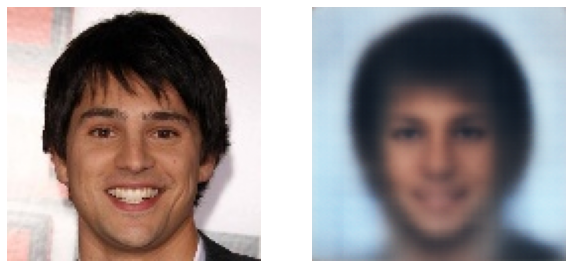

In [9]:
img = cv2.resize(cv2.cvtColor(cv2.imread('./dataset/100k/000825.jpg'), cv2.COLOR_BGR2RGB),(128, 128)) # Read & Resize
img = tf.expand_dims((img - np.min(img)) / (np.max(img) - np.min(img)) , 0).numpy() # Normalize & Expand dims
rec = autoencoder(img).numpy()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1), plt.imshow(np.squeeze(img, axis=0)), plt.axis('off')
plt.subplot(1, 2, 2), plt.imshow(np.squeeze(rec, axis=0)), plt.axis('off')  